# Assignment_3_HIT140_Group 10_Sydney
# Investigation B — Step by step Walkthrough

**Topic: Bat vs. Rat: The Forage Files**

**Uncovering the wild truth behind nocturnal food fights**

The steps that we covered thorughout the project:

**Investigations:**  
- **A:** Predation-risk perception — Do bats perceive rats as predators?  
- **B:** Seasonality — Do behaviours change with **winter** vs **spring**?  

**Project goals**
- Load and clean data (dataset1.csv, dataset2.csv)
- Engineer features; link bat landings to 30-min periods
- Investigation A: descriptive + inferential tests
- Investigation B: seasonal analysis (winter vs spring), with interactions and robustness checks
- Save all outputs (figures & tables) to `outputs/`


# 1. Environment Setup (Ferdous and Rana)

In [1]:
# !pip install -q statsmodels scipy

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, os, math
from pathlib import Path
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams.update({"figure.dpi": 140})
pd.set_option("display.max_columns", 150)

# Output folders
OUT = Path("outputs"); FIG = OUT/"figures"; TAB = OUT/"tables"
for p in [OUT, FIG, TAB]: p.mkdir(parents=True, exist_ok=True)
print("Saving figures to:", FIG.resolve())
print("Saving tables  to:", TAB.resolve())





Saving figures to: /content/outputs/figures
Saving tables  to: /content/outputs/tables


## 2. Load data (Ferdous and Rana)
Upload `dataset1.csv` and `dataset2.csv` from your project package or LMS.

In [2]:
# If needed in Colab:
# from google.colab import files
# uploaded = files.upload()  # choose dataset1.csv and dataset2.csv

D1 = "dataset1.csv"   # per bat landing (Investigation A granularity)
D2 = "dataset2.csv"   # 30-min observation periods

d1 = pd.read_csv(D1)
d2 = pd.read_csv(D2)

print("Shapes:", d1.shape, d2.shape)
display(d1.head(3))
display(d2.head(3))


Shapes: (907, 12) (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.0,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.0,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.0,0.0,0


## 3) Cleaning & data quality checks (Sabbir and Mahdee)
We inspect dtypes, missingness, and simple distributions to understand required cleaning steps




In [3]:
# Parse datetimes (your files often use D/M/Y)
for c in ["start_time","sunset_time","rat_period_start","rat_period_end"]:
    if c in d1.columns:
        d1[c] = pd.to_datetime(d1[c], errors="coerce", dayfirst=True)

if "time" in d2.columns:
    d2["time"] = pd.to_datetime(d2["time"], errors="coerce", dayfirst=True)

# Numeric coercion (ignore if missing)
num_d1 = ["risk","reward","seconds_after_rat_arrival","bat_landing_to_food","hours_after_sunset"]
for c in num_d1:
    if c in d1.columns:
        d1[c] = pd.to_numeric(d1[c], errors="coerce")

num_d2 = ["hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number","month"]
for c in num_d2:
    if c in d2.columns:
        d2[c] = pd.to_numeric(d2[c], errors="coerce")

# Tidy text
for df in (d1, d2):
    for c in ["month","season","habit"]:
        if c in df.columns and df[c].dtype=="object":
            df[c] = df[c].astype(str).str.strip()

print("Missing (top):")
print("d1:\n", d1.isna().sum().sort_values(ascending=False).head(10))
print("\nd2:\n", d2.isna().sum().sort_values(ascending=False).head(10))


Missing (top):
d1:
 start_time                   0
bat_landing_to_food          0
habit                        0
rat_period_start             0
rat_period_end               0
seconds_after_rat_arrival    0
risk                         0
reward                       0
month                        0
sunset_time                  0
dtype: int64

d2:
 time                  0
month                 0
hours_after_sunset    0
bat_landing_number    0
food_availability     0
rat_minutes           0
rat_arrival_number    0
dtype: int64


**3A. Quick diagnosis as we don't find any missing values**

In [4]:
# Quick diagnostic to check what month/season info exists
print("=== Season/Month diagnostics ===\n")

if "season" in d1.columns:
    print("d1['season'] unique values:", d1['season'].unique())
else:
    print("No 'season' column in d1")

if "month" in d1.columns:
    print("d1['month'] unique values:", d1['month'].unique())
else:
    print("No 'month' column in d1")

if "month" in d2.columns:
    print("\nd2['month'] unique values:", d2['month'].unique())
else:
    print("No 'month' column in d2")

if "start_time" in d1.columns:
    print("\nSample d1 start_time:", d1['start_time'].head(5))


=== Season/Month diagnostics ===

d1['season'] unique values: [0 1]
d1['month'] unique values: [0 1 2 3 4 5]

d2['month'] unique values: [0 1 2 3 4 5 6]

Sample d1 start_time: 0   2017-12-30 18:37:00
1   2017-12-30 19:51:00
2   2017-12-30 19:51:00
3   2017-12-30 19:52:00
4   2017-12-30 19:54:00
Name: start_time, dtype: datetime64[ns]


## 4) Feature Engineering (A & B) (Ferdous and Rana)

**4A. Season Derivation (seasons: 0=winter, 1=spring)** (Ferdous)


In [5]:
# Map coded season directly from d1 (0=winter, 1=spring)
if "season" in d1.columns:
    d1["season"] = pd.to_numeric(d1["season"], errors="coerce").map({0: "winter", 1: "spring"})
else:
    d1["season"] = np.nan  # should not happen with your file

# Focus contrast: winter/spring only
d1["season_ws"] = d1["season"].where(d1["season"].isin(["winter","spring"]), np.nan)

# After/before rat indicator (1 if landing at/after first rat arrival)
if "seconds_after_rat_arrival" in d1.columns:
    d1["after_rat"] = (pd.to_numeric(d1["seconds_after_rat_arrival"], errors="coerce") >= 0).astype("Int64")
else:
    d1["after_rat"] = pd.NA

# Minutes after sunset helper
if "hours_after_sunset" in d1.columns:
    d1["mins_after_sunset"] = pd.to_numeric(d1["hours_after_sunset"], errors="coerce") * 60.0

print("✅ Season mapping complete (0→winter, 1→spring).")
print("\nd1['season'] value counts:\n", d1["season"].value_counts(dropna=False))
print("\nd1['season_ws'] value counts:\n", d1["season_ws"].value_counts(dropna=False))
display(d1[["start_time","season","season_ws","after_rat","hours_after_sunset"]].head(8))


✅ Season mapping complete (0→winter, 1→spring).

d1['season'] value counts:
 season
spring    756
winter    151
Name: count, dtype: int64

d1['season_ws'] value counts:
 season_ws
spring    756
winter    151
Name: count, dtype: int64


,start_time,season,season_ws,after_rat,hours_after_sunset
0,2017-12-30 18:37:00,winter,winter,1,1.870833
1,2017-12-30 19:51:00,winter,winter,1,3.100833
2,2017-12-30 19:51:00,winter,winter,1,3.107500
3,2017-12-30 19:52:00,winter,winter,1,3.126944
4,2017-12-30 19:54:00,winter,winter,1,3.150000
5,2017-12-30 19:54:00,winter,winter,1,3.155833
6,2017-12-30 19:54:00,winter,winter,1,3.166389
7,2017-12-26 21:24:00,winter,winter,1,4.684444


**4b. Robust WS derivation with fallback to coded season** (Rana)

In [6]:
def count_ws(df):
    return int(df.get('season_ws', pd.Series(index=df.index)).isin(['winter','spring']).sum())

# If we already have some WS rows from the date-based approach, keep them
ws_count = count_ws(d1)
print(f"[Season check] WS rows from dates: {ws_count}")

if ws_count == 0:
    print("[Season check] No winter/spring from dates — trying coded 'season' fallback...")

    # 1) If there is a numeric/binary 'season' column, map it to WS labels
    coded = None
    if 'season' in d1.columns:
        # Try to understand the coding: convert to numeric safely
        s_num = pd.to_numeric(d1['season'], errors='coerce')
        unique_vals = set(s_num.dropna().unique().tolist())
        print(f"[Season check] season unique (numeric): {sorted(unique_vals)}")

        # Heuristic: if it's binary (subset of {0,1}), use it
        if unique_vals.issubset({0,1}):
            coded = s_num
        elif unique_vals.issubset({1,2}):
            # Some datasets use 1/2 coding — remap to 0/1
            coded = s_num.replace({1:0, 2:1})
        # else leave coded=None

    # 2) If coded available, map to WS
    if coded is not None:
        # ---- Adjust this if your instructor defined the opposite mapping ----
        MAP_0_IS = 'winter'   # change to 'spring' if needed
        MAP_1_IS = 'spring'   # change to 'winter' if needed
        d1['season'] = np.where(coded == 0, MAP_0_IS,
                         np.where(coded == 1, MAP_1_IS, 'unknown'))
        d1['season_ws'] = np.where(d1['season'].isin(['winter','spring']), d1['season'], 'non-ws')
        ws_count = count_ws(d1)
        print(f"[Season check] WS rows after coded fallback: {ws_count}")
    else:
        # 3) As a last resort, treat *all* rows as non-WS so the pipeline still runs
        # (plots will say 'no WS rows' to be transparent)
        d1['season'] = d1.get('season', pd.Series(['unknown']*len(d1), index=d1.index))
        d1['season_ws'] = 'non-ws'
        print("[Season check] No usable coded season found; marking all as non-ws.")

# Create is_ws flag used later
d1['is_ws'] = d1['season_ws'].isin(['winter','spring'])

print("\nSeason value counts:\n", d1['season'].value_counts(dropna=False))
print("\nseason_ws value counts:\n", d1['season_ws'].value_counts(dropna=False))
print("\nSample:\n", d1[['start_time','season','season_ws']].head(5))


[Season check] WS rows from dates: 907

Season value counts:
 season
spring    756
winter    151
Name: count, dtype: int64

season_ws value counts:
 season_ws
spring    756
winter    151
Name: count, dtype: int64

Sample:
            start_time  season season_ws
0 2017-12-30 18:37:00  winter    winter
1 2017-12-30 19:51:00  winter    winter
2 2017-12-30 19:51:00  winter    winter
3 2017-12-30 19:52:00  winter    winter
4 2017-12-30 19:54:00  winter    winter


## 5) Link per-landing records to 30‑min platform windows (Sabbir)

**As-of merge to link landings (d1) to periods (d2)**

We attach `rat_arrival_number` and other period-level variables by joining each **landing** to the **most recent** 30‑min observation window whose start `time` is **≤ landing time**, then keep only rows where the landing falls before the period end.

In [7]:

# We align each landing to the latest d2['time'] <= start_time and keep rows within 30 minutes.
if ("time" in d2.columns) and ("start_time" in d1.columns):
    d2_sorted = d2.sort_values("time").copy()
    d2_sorted["period_end"] = d2_sorted["time"] + pd.to_timedelta(30, "m")

    keep_cols = ["time","period_end","rat_arrival_number","rat_minutes","food_availability","hours_after_sunset"]
    keep_cols = [c for c in keep_cols if c in d2_sorted.columns]

    d1_sorted = d1.sort_values("start_time").copy()
    merged = pd.merge_asof(
        d1_sorted,
        d2_sorted[keep_cols].sort_values("time"),
        left_on="start_time", right_on="time",
        direction="backward", allow_exact_matches=True
    )
    within = merged["start_time"].notna() & merged["time"].notna() & (merged["start_time"] < merged["period_end"])
    d = merged.loc[within].copy()
else:
    # Fallback if d2 time not present—continue with d1 only (keeps models working)
    d = d1.copy()
    if "rat_arrival_number" not in d.columns:
        d["rat_arrival_number"] = np.nan

print("Linked dataset shape:", d.shape)
display(d.head(5))


Linked dataset shape: (907, 22)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset_x,season,season_ws,after_rat,mins_after_sunset,is_ws,time,period_end,rat_arrival_number,rat_minutes,food_availability,hours_after_sunset_y
0,2017-12-26 20:57:00,1.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,2017-12-26 16:43:00,4.248611,winter,winter,1,254.916667,True,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,2.968874,4.0
1,2017-12-26 20:57:00,5.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,2017-12-26 16:43:00,4.237500,winter,winter,1,254.250000,True,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,2.968874,4.0
2,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,2017-12-26 16:43:00,4.693611,winter,winter,1,281.616667,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5
3,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,2017-12-26 16:43:00,4.684444,winter,winter,1,281.066667,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5
4,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,2017-12-26 16:43:00,4.691389,winter,winter,1,281.483333,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5


## 6) Final analytic dataset for investigation B (Mahdee)

In [8]:
analytic = d.dropna(subset=["risk","reward"]).copy()
analytic["risk"] = pd.to_numeric(analytic["risk"], errors="coerce").astype(int)
analytic["reward"] = pd.to_numeric(analytic["reward"], errors="coerce").astype(int)

# Ensure the derived columns exist (carry from d1 if needed)
for col in ["season","season_ws","after_rat","hours_after_sunset","mins_after_sunset"]:
    if col not in analytic.columns and col in d1.columns:
        analytic[col] = d1.loc[analytic.index, col]

analytic["is_ws"] = analytic["season_ws"].isin(["winter","spring"])

print("Analytic shape:", analytic.shape)
print("season_ws counts:\n", analytic["season_ws"].value_counts(dropna=False))
display(analytic.head(5))


Analytic shape: (907, 23)
season_ws counts:
 season_ws
spring    756
winter    151
Name: count, dtype: int64


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset_x,season,season_ws,after_rat,mins_after_sunset,is_ws,time,period_end,rat_arrival_number,rat_minutes,food_availability,hours_after_sunset_y,hours_after_sunset
0,2017-12-26 20:57:00,1.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,2017-12-26 16:43:00,4.248611,winter,winter,1,254.916667,True,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,2.968874,4.0,1.870833
1,2017-12-26 20:57:00,5.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,2017-12-26 16:43:00,4.237500,winter,winter,1,254.250000,True,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,2.968874,4.0,3.100833
2,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,2017-12-26 16:43:00,4.693611,winter,winter,1,281.616667,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5,3.107500
3,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,2017-12-26 16:43:00,4.684444,winter,winter,1,281.066667,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5,3.126944
4,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,2017-12-26 16:43:00,4.691389,winter,winter,1,281.483333,True,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,2.561404,4.5,3.150000


# **7) Descriptive analysis (Seasonal) (All together)**

**7A. Behaviour distribution by season (winter vs spring)** (Sabbir)

WS rows: 907 
 season_ws
spring    756
winter    151
Name: count, dtype: int64


risk,Avoidance,Risk-taking
season_ws,,
Spring,392,364
Winter,66,85


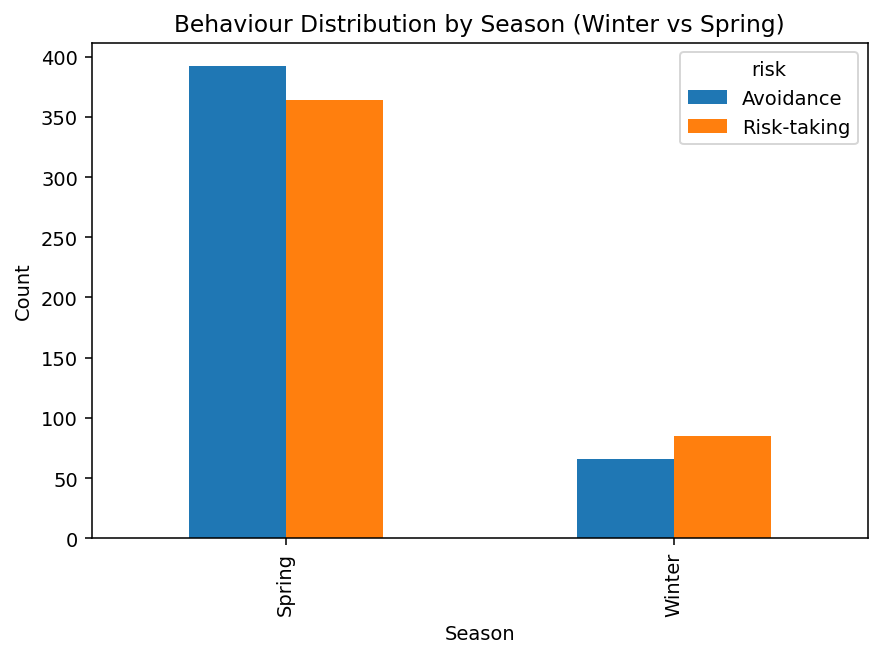

In [9]:
import matplotlib.pyplot as plt

ws = analytic.loc[analytic["is_ws"]].copy()
print("WS rows:", len(ws), "\n", ws["season_ws"].value_counts(dropna=False))

if len(ws) == 0:
    print("No winter/spring rows — check Step 3 mapping or season codes.")
else:
    beh_by_season = pd.crosstab(
        ws["season_ws"].astype(str).str.title(),
        ws["risk"].map({0: "Avoidance", 1: "Risk-taking"})
    ).reindex(columns=["Avoidance","Risk-taking"], fill_value=0)

    display(beh_by_season)

    ax = beh_by_season.plot(kind="bar")
    ax.set_title("Behaviour Distribution by Season (Winter vs Spring)")
    ax.set_ylabel("Count"); ax.set_xlabel("Season")
    plt.tight_layout(); plt.savefig(FIG/"B_behaviour_by_season.png"); plt.show()


**7B. Before vs After rat arrival, by season** (Mahdee)

risk,Avoidance,Risk-taking
after_rat,,
After,66,85


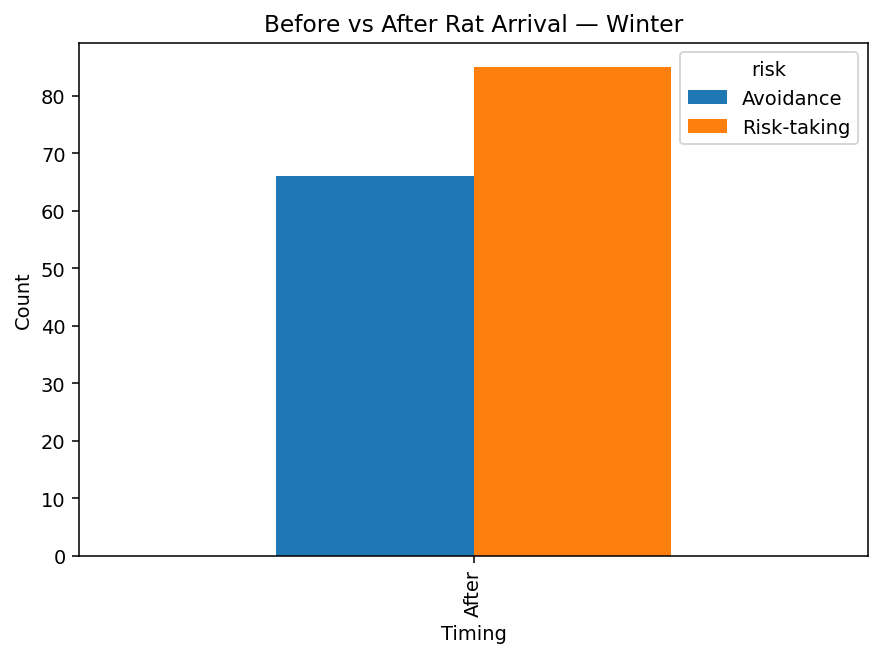

risk,Avoidance,Risk-taking
after_rat,,
After,392,364


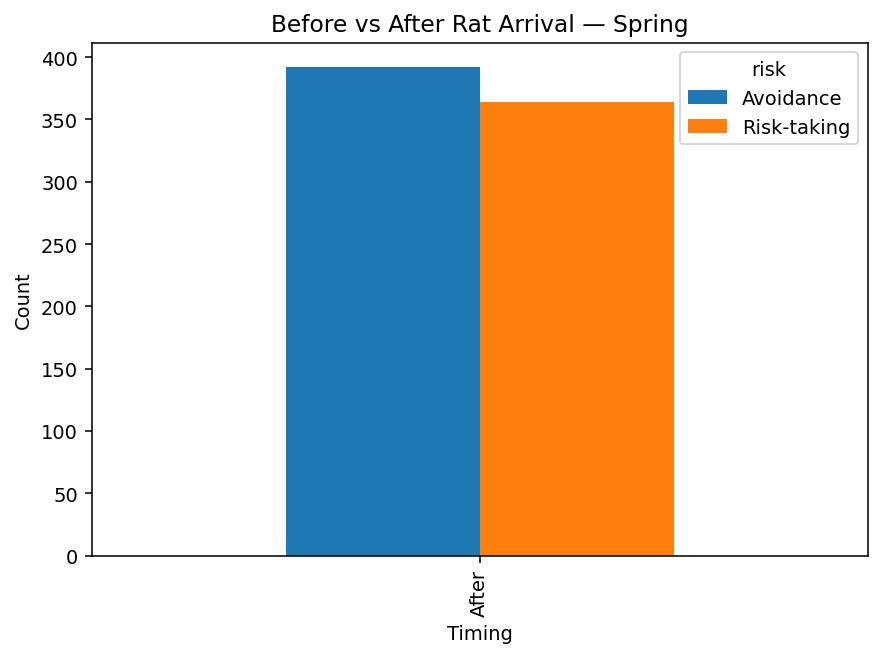

In [10]:
if len(ws) > 0 and "after_rat" in ws.columns:
    ws_rat = ws.dropna(subset=["after_rat"]).copy()
    for s in ["winter","spring"]:
        sub = ws_rat[ws_rat["season_ws"] == s]
        if len(sub) == 0:
            print(f"No rows for {s}.")
            continue
        ct = pd.crosstab(
            sub["after_rat"].map({0: "Before", 1: "After"}),
            sub["risk"].map({0: "Avoidance", 1: "Risk-taking"})
        ).reindex(columns=["Avoidance","Risk-taking"], fill_value=0)
        display(ct)
        ct.plot(kind="bar"); plt.title(f"Before vs After Rat Arrival — {s.title()}")
        plt.ylabel("Count"); plt.xlabel("Timing")
        plt.tight_layout(); plt.savefig(FIG/f"B_before_after_{s}.png"); plt.show()
else:
    print("Skipping 6B — no WS rows or after_rat missing.")


**7C. Reward rate by behaviour within season** (Ferdous)

mean  count
season_ws risk                        
spring    Avoidance    0.852041    392
          Risk-taking  0.260989    364
winter    Avoidance    0.787879     66
          Risk-taking  0.035294     85

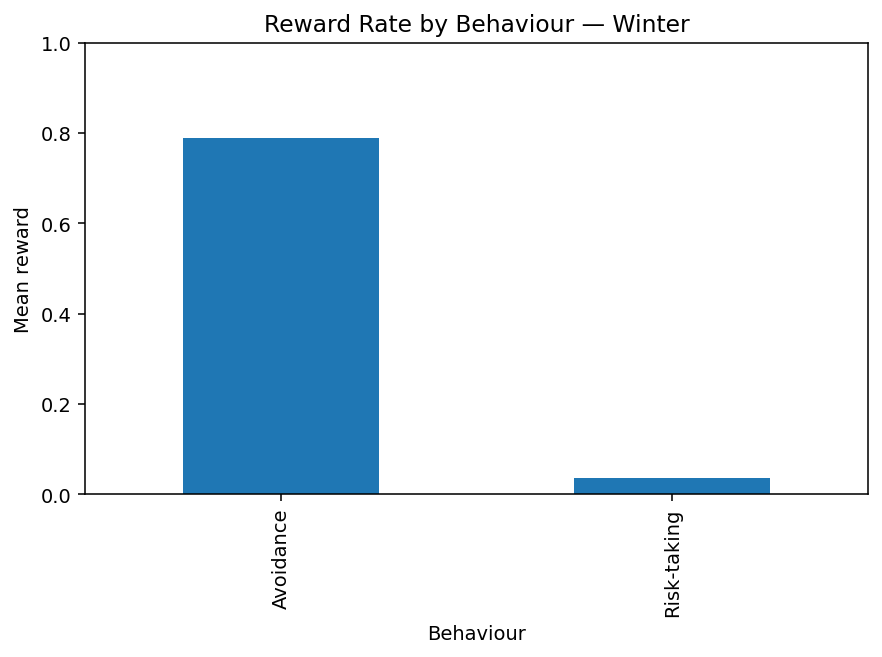

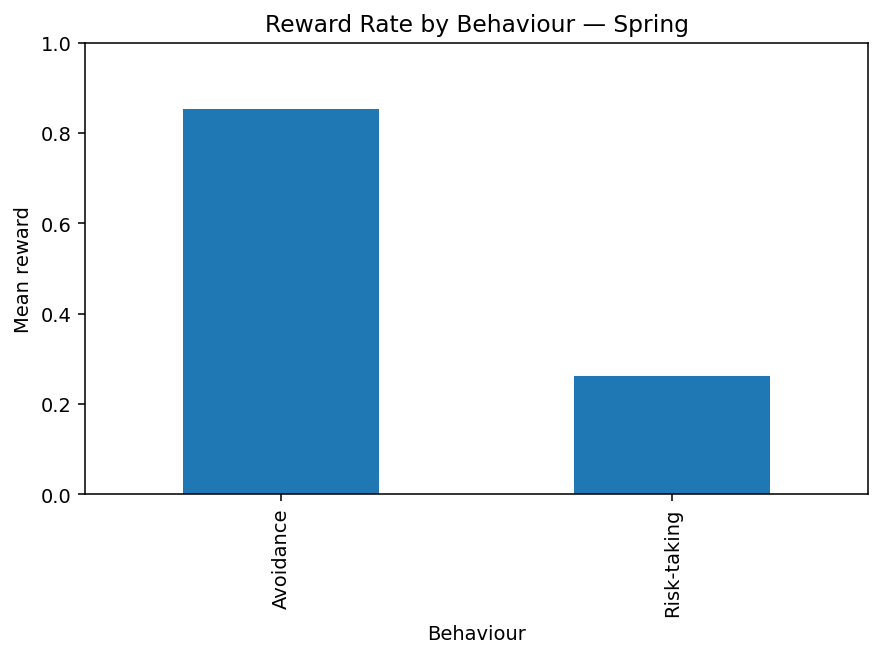

In [11]:
if len(ws) > 0:
    rb = ws.groupby(["season_ws","risk"])["reward"].agg(["mean","count"]).rename(index={0:"Avoidance",1:"Risk-taking"})
    display(rb); rb.to_csv(TAB/"B_reward_by_behaviour_season.csv")

    for s in ["winter","spring"]:
        sub = ws[ws["season_ws"] == s]
        if len(sub) == 0:
            print(f"No rows for {s}."); continue
        m = sub.groupby("risk")["reward"].mean().rename(index={0:"Avoidance",1:"Risk-taking"})
        m.plot(kind="bar"); plt.ylim(0,1); plt.title(f"Reward Rate by Behaviour — {s.title()}")
        plt.ylabel("Mean reward"); plt.xlabel("Behaviour")
        plt.tight_layout(); plt.savefig(FIG/f"B_reward_by_behaviour_{s}.png"); plt.show()


**7D. Time trend: risk-taking vs hours after sunset, by season** (Rana)

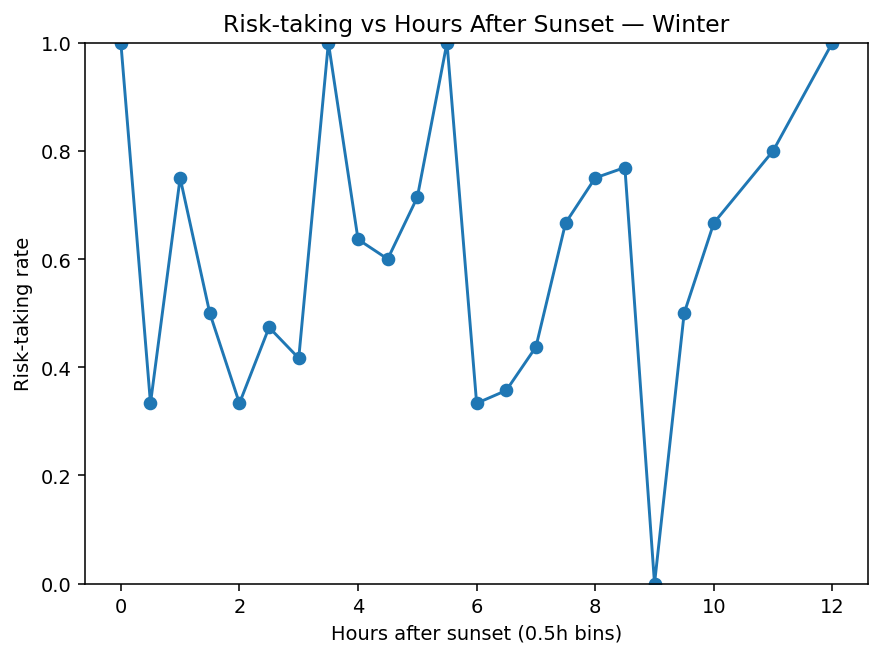

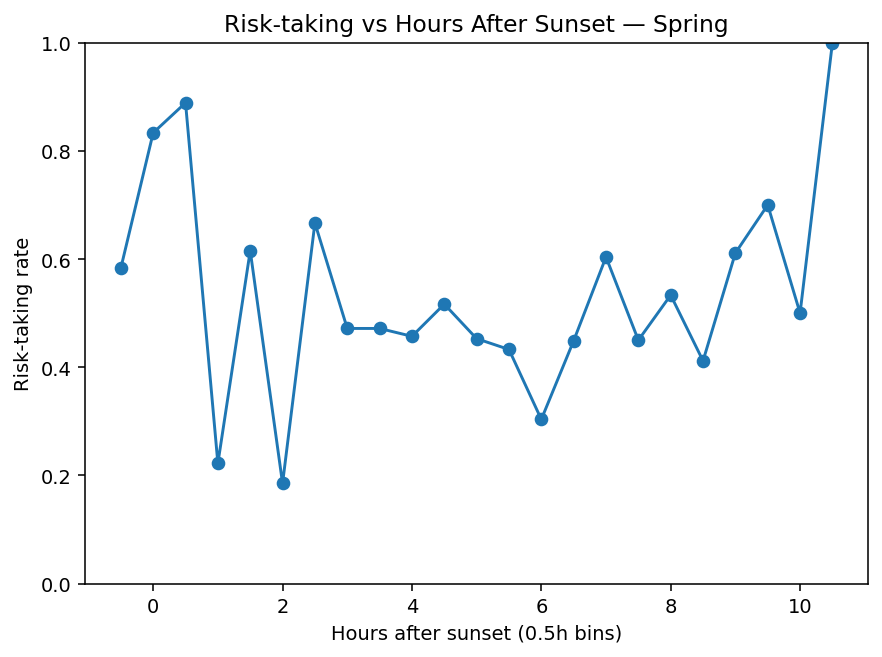

In [12]:
if len(ws) > 0 and "hours_after_sunset" in ws.columns:
    for s in ["winter","spring"]:
        sub = ws[(ws["season_ws"]==s) & (ws["hours_after_sunset"].notna())].copy()
        if len(sub) == 0:
            print(f"No time rows for {s}."); continue
        sub["hour_bin"] = np.floor(sub["hours_after_sunset"]*2)/2.0
        trend = sub.groupby("hour_bin")["risk"].mean().reset_index(name="risk_rate")
        plt.plot(trend["hour_bin"], trend["risk_rate"], marker="o")
        plt.title(f"Risk-taking vs Hours After Sunset — {s.title()}")
        plt.xlabel("Hours after sunset (0.5h bins)"); plt.ylabel("Risk-taking rate"); plt.ylim(0,1)
        plt.tight_layout(); plt.savefig(FIG/f"B_risk_trend_{s}.png"); plt.show()
else:
    print("Skipping 6D — no WS rows or hours_after_sunset missing.")


# 8) Inferential analysis (Seasonal) (Mahdee and Ferdous)

**8A. Chi-square tests** (Mahdee)

In [13]:
from scipy.stats import chi2_contingency
import numpy as np

def chisq_with_effect(ct):
    chi2, p, dof, exp = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, c = ct.shape
    V = np.sqrt(chi2/(n*(min(r,c)-1))) if min(r,c) > 1 else np.nan  # Cramér’s V
    return chi2, p, dof, V, pd.DataFrame(exp, index=ct.index, columns=ct.columns)

if len(ws) > 0:
    # Season × Behaviour
    ct_beh = pd.crosstab(ws["season_ws"], ws["risk"])
    if ct_beh.shape == (2,2):
        chi2,p,dof,V,exp = chisq_with_effect(ct_beh)
        print(f"Season × Behaviour: chi2={chi2:.2f}, p={p:.4g}, dof={dof}, V={V:.3f}")
        display(ct_beh, exp)
    else:
        print("Season × Behaviour not 2×2; raw table below:"); display(ct_beh)

    # Season × Reward
    ct_rew = pd.crosstab(ws["season_ws"], ws["reward"])
    if ct_rew.shape == (2,2):
        chi2,p,dof,V,exp = chisq_with_effect(ct_rew)
        print(f"Season × Reward: chi2={chi2:.2f}, p={p:.4g}, dof={dof}, V={V:.3f}")
        display(ct_rew, exp)
    else:
        print("Season × Reward not 2×2; raw table below:"); display(ct_rew)

    # Within-season examples: AfterRat × Behaviour and Behaviour × Reward
    ws_rat = ws.dropna(subset=["after_rat"]).copy() if "after_rat" in ws.columns else pd.DataFrame()
    for s in ["winter","spring"]:
        sub = ws_rat[ws_rat["season_ws"]==s]
        if len(sub) > 0:
            ct_ab = pd.crosstab(sub["after_rat"], sub["risk"])
            if ct_ab.shape == (2,2):
                chi2,p,dof,V,_ = chisq_with_effect(ct_ab)
                print(f"{s.title()} — AfterRat × Behaviour: chi2={chi2:.2f}, p={p:.4g}, V={V:.3f}")
            ct_rr = pd.crosstab(sub["risk"], sub["reward"])
            if ct_rr.shape == (2,2):
                chi2,p,dof,V,_ = chisq_with_effect(ct_rr)
                print(f"{s.title()} — Behaviour × Reward: chi2={chi2:.2f}, p={p:.4g}, V={V:.3f}")
else:
    print("Skipping chi-square — no WS rows.")


Season × Behaviour: chi2=3.02, p=0.08219, dof=1, V=0.058


risk,0,1
season_ws,,
spring,392,364
winter,66,85


risk,0,1
season_ws,,
spring,381.750827,374.249173
winter,76.249173,74.750827


Season × Reward: chi2=20.08, p=7.436e-06, dof=1, V=0.149


reward,0,1
season_ws,,
spring,327,429
winter,96,55


reward,0,1
season_ws,,
spring,352.577729,403.422271
winter,70.422271,80.577729


Winter — Behaviour × Reward: chi2=87.65, p=7.819e-21, V=0.762
Spring — Behaviour × Reward: chi2=266.23, p=7.535e-60, V=0.593


**8B. Logistic regression (with season & interactions)** (Ferdous)

Rows for regression (after cleaning): 907

[2x2] season_ws × risk
risk         0    1
season_ws          
spring     392  364
winter      66   85

Logistic Regression (sklearn, L2) — Odds Ratios


,OR
Intercept,0.949003
seconds_after_rat_arrival_z,1.063433
rat_arrival_number_z,1.046408
hours_after_sunset_z,1.033556
season_winter,1.372063


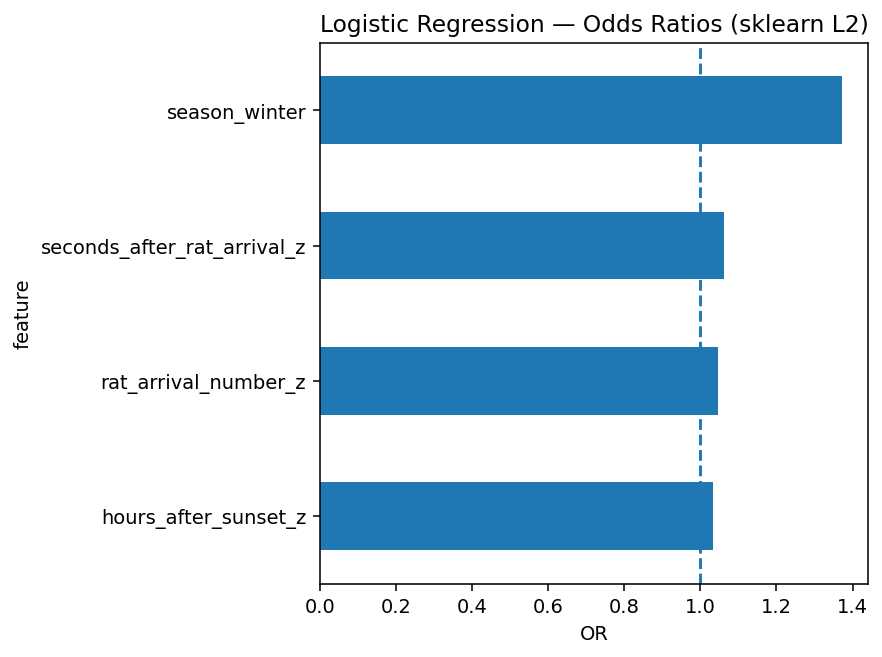

In [14]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# scikit-learn is available in Colab by default
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

def describe_ct(df, a, b):
    try:
        print(f"\n[2x2] {a} × {b}")
        print(pd.crosstab(df[a], df[b]))
    except Exception as e:
        print(f"Could not tabulate {a}×{b}: {e}")

if len(ws) == 0:
    print("Skipping logistic regression — no WS rows.")
else:
    # Start from the WS-only data
    reg = ws.copy()

    # Keep rows where 'risk' is known
    reg = reg.dropna(subset=['risk']).copy()
    reg['risk'] = reg['risk'].astype(int)

    # Prefer to include after_rat if present and non-constant
    use_after = 'after_rat' in reg.columns and reg['after_rat'].notna().any() and reg['after_rat'].nunique() > 1
    if use_after:
        reg = reg.dropna(subset=['after_rat']).copy()
        reg['after_rat'] = reg['after_rat'].astype(int)

    # Make z-scored versions of continuous predictors if available & variable
    z_cols = []
    for c in ['seconds_after_rat_arrival', 'rat_arrival_number', 'hours_after_sunset']:
        if c in reg.columns:
            reg[c] = pd.to_numeric(reg[c], errors='coerce')
            if reg[c].notna().sum() > 0 and reg[c].std(ddof=0) > 0:
                reg[c + '_z'] = (reg[c] - reg[c].mean()) / reg[c].std(ddof=0)
                z_cols.append(c + '_z')

    # Season term only if both winter & spring are present
    season_ok = 'season_ws' in reg.columns and reg['season_ws'].isin(['winter','spring']).sum() > 0
    if season_ok and reg.loc[reg['season_ws'].isin(['winter','spring']), 'season_ws'].nunique() == 2:
        season_ok = True
    else:
        season_ok = False

    print("Rows for regression (after cleaning):", len(reg))
    if use_after:
        describe_ct(reg, 'after_rat', 'risk')
    if season_ok:
        describe_ct(reg, 'season_ws', 'risk')

    # -------- Build feature matrix X --------
    feat_cols = []
    if use_after:
        feat_cols.append('after_rat')
    feat_cols += z_cols

    # add season dummies if usable
    if season_ok:
        reg['_season_ws'] = reg['season_ws'].where(reg['season_ws'].isin(['winter','spring']))
        season_dum = pd.get_dummies(reg['_season_ws'], prefix='season', drop_first=True)  # ref='winter'
    else:
        season_dum = pd.DataFrame(index=reg.index)

    X = pd.concat([reg[feat_cols], season_dum], axis=1)

    # Drop zero-variance columns
    var = X.var(axis=0)
    zero_var_cols = var[var == 0].index.tolist()
    if zero_var_cols:
        print("Dropping zero-variance columns:", zero_var_cols)
        X = X.drop(columns=zero_var_cols, errors='ignore')

    # Drop duplicate columns (exact duplicates)
    if X.shape[1] > 1:
        X_T = X.T.drop_duplicates()
        if X_T.shape[0] < X.shape[1]:
            dup_count = X.shape[1] - X_T.shape[0]
            print(f"Dropping {dup_count} duplicate column(s) (perfect collinearity detected).")
            X = X.loc[:, X_T.index]

    # Final guard: ensure we still have predictors
    if X.shape[1] == 0:
        print("All predictors are constant/collinear. Falling back to an intercept-only model is not informative.")
        print("Tip: ensure 'after_rat' varies and both winter/spring exist in ws. You can also try removing one term.")
    else:
        y = reg['risk'].astype(int).values

        # Fit L2-regularized logistic regression
        # class_weight='balanced' helps if classes are imbalanced, C=1.0 (ridge strength), plenty of iterations
        clf = LogisticRegression(
            penalty='l2', C=1.0, solver='lbfgs', max_iter=5000, class_weight='balanced'
        )
        clf.fit(X.values, y)

        coefs = pd.Series(clf.coef_[0], index=X.columns, name='coef')
        OR = np.exp(coefs)
        res = pd.DataFrame({'OR': OR})
        res.index.name = 'feature'

        # Add intercept OR for completeness
        res_intercept = pd.DataFrame({'OR': [np.exp(clf.intercept_[0])]}, index=['Intercept'])
        res = pd.concat([res_intercept, res])

        print("\nLogistic Regression (sklearn, L2) — Odds Ratios")
        display(res)
        res.to_csv(TAB/'B_logit_sklearn_or.csv')

        # Nice quick plot of ORs (excluding intercept)
        if len(OR) > 0:
            OR.sort_values().plot(kind='barh')
            plt.axvline(1.0, linestyle='--')
            plt.title('Logistic Regression — Odds Ratios (sklearn L2)')
            plt.xlabel('OR')
            plt.tight_layout(); plt.savefig(FIG/'B_logit_sklearn_or.png'); plt.show()


**8C. Permutation robustness (Season × Behaviour)** (Sabbir)

In [15]:
from scipy.stats import chi2_contingency
import math

if len(ws) > 0:
    obs = pd.crosstab(ws["season_ws"], ws["risk"])
    if obs.shape == (2,2):
        def cramers_v(chi2, n, r, c): return math.sqrt(chi2/(n*(min(r,c)-1)))
        chi_obs, p_obs, dof_obs, _ = chi2_contingency(obs)
        V_obs = cramers_v(chi_obs, obs.values.sum(), *obs.shape)

        B = 2000; rng = np.random.default_rng(42)
        V_perm = np.empty(B)
        y = ws["risk"].to_numpy().copy()
        for b in range(B):
            rng.shuffle(y)
            ct = pd.crosstab(ws["season_ws"], y)
            chi, p, dof, _ = chi2_contingency(ct)
            V_perm[b] = cramers_v(chi, ct.values.sum(), *ct.shape)
        p_perm = (np.sum(V_perm >= V_obs) + 1)/(B + 1)
        print(f"Permutation Cramér’s V: observed={V_obs:.3f}, p≈{p_perm:.4f}")
    else:
        print("Permutation skipped — Season×Behaviour not 2×2.")
else:
    print("Permutation skipped — no WS rows.")


Permutation Cramér’s V: observed=0.058, p≈0.0725


# 9) Extended Logisitc Regression (Rana)

This model from Step 8B with external covariates. Only run this if ext_loaded == True.

In [16]:
# Add this line to define ext_loaded
ext_loaded = False

if ext_loaded:
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt

    ws_ext = analytic.loc[analytic.get("season_ws","").isin(["winter","spring"])].copy()
    ws_ext = ws_ext.dropna(subset=["risk"]).copy()
    ws_ext["risk"] = ws_ext["risk"].astype(int)

    # Choose features you want to add (only those that exist & have variance)
    add_feats = []
    for c in ["temp_c","wind_kph","rain_mm","moon_illum"]:
        if c in ws_ext.columns and ws_ext[c].notna().sum() > 0 and ws_ext[c].std(ddof=0) > 0:
            # don't z-score yet; we'll handle scaling via imputation logic below if desired
            add_feats.append(c)

    # Keep the core features that worked for you earlier
    base_feats = []
    if "after_rat" in ws_ext.columns and ws_ext["after_rat"].notna().any() and ws_ext["after_rat"].nunique() > 1:
        ws_ext["after_rat"] = ws_ext["after_rat"].astype("Int64")
        base_feats.append("after_rat")

    for c in ["seconds_after_rat_arrival","rat_arrival_number","hours_after_sunset"]:
        if c in ws_ext.columns and ws_ext[c].notna().sum() > 0 and ws_ext[c].std(ddof=0) > 0:
            base_feats.append(c)

    # Add season dummies if both levels exist
    season_ok = ws_ext.get("season_ws","").isin(["winter","spring"]).sum() > 0 and \
                ws_ext.loc[ws_ext["season_ws"].isin(["winter","spring"]),"season_ws"].nunique() == 2
    if season_ok:
        ws_ext["_season_ws"] = ws_ext["season_ws"].where(ws_ext["season_ws"].isin(["winter","spring"]))
        season_dum = pd.get_dummies(ws_ext["_season_ws"], prefix="season", drop_first=True)  # ref = winter
    else:
        season_dum = pd.DataFrame(index=ws_ext.index)

    # Build X matrix (raw numeric + dummies)
    X = pd.concat([ws_ext[base_feats + add_feats], season_dum], axis=1)

    # ---------- IMPUTE MISSING VALUES (fix NaNs) ----------
    # Fill numeric columns with column median; dummies with 0
    for col in X.columns:
        if pd.api.types.is_numeric_dtype(X[col]):
            med = X[col].median()
            X[col] = X[col].fillna(med)
        else:
            X[col] = X[col].fillna(0)

    # After imputation, ensure after_rat is int
    if "after_rat" in X.columns:
        X["after_rat"] = X["after_rat"].round().astype(int)

    # Drop zero-variance columns
    var = X.var(axis=0)
    zero_var_cols = var[var == 0].index.tolist()
    if zero_var_cols:
        print("External model: dropping zero-variance columns:", zero_var_cols)
        X = X.drop(columns=zero_var_cols, errors="ignore")

    # Drop duplicate columns (perfect collinearity)
    if X.shape[1] > 1:
        X_T = X.T.drop_duplicates()
        if X_T.shape[0] < X.shape[1]:
            dup_count = X.shape[1] - X_T.shape[0]
            print(f"External model: dropping {dup_count} duplicate column(s).")
            X = X.loc[:, X_T.index]

    # Align y (risk) and drop any remaining NaNs defensively
    y = ws_ext.loc[X.index, "risk"].astype(int).values

    # Final guard
    if X.shape[1] == 0:
        print("External model: no usable predictors after cleaning (skipping).")
    else:
        # (Optional) z-score continuous columns now for interpretability
        cont_cols = [c for c in X.columns if c in (base_feats + add_feats) and X[c].std(ddof=0) > 0]
        for c in cont_cols:
            X[c] = (X[c] - X[c].mean()) / X[c].std(ddof=0)

        # Fit L2-regularized logistic regression
        clf_ext = LogisticRegression(
            penalty="l2", C=1.0, solver="lbfgs", max_iter=5000, class_weight="balanced"
        ).fit(X.values, y)

        or_ext = np.exp(pd.Series(clf_ext.coef_[0], index=X.columns, name="OR"))
        or_table_ext = or_ext.to_frame()
        print("\nExtended Logistic (with external covariates) — Odds Ratios")
        display(or_table_ext)
        or_table_ext.to_csv(TAB/"B_logit_sklearn_or_with_external.csv")

        # Plot (excluding intercept)
        or_ext.sort_values().plot(kind="barh")
        plt.axvline(1.0, linestyle="--")
        plt.title("Logistic ORs with External Covariates (sklearn L2)")
        plt.xlabel("OR")
        plt.tight_layout(); plt.savefig(FIG/"B_logit_sklearn_or_with_external.png"); plt.show()
else:
    print("No external dataset provided; Step 8 completed without merge.")

No external dataset provided; Step 8 completed without merge.



# 10) Save outputs & environment manifest


In [17]:

import json, sys, platform, pkgutil
from pathlib import Path

# Ensure output folders exist (if you ran only parts of the notebook)
OUT = Path("outputs"); FIG = OUT/"figures"; TAB = OUT/"tables"
for p in [OUT, FIG, TAB]: p.mkdir(parents=True, exist_ok=True)

# Inventory of generated artifacts
artifact_list = {
    "figures": sorted([p.name for p in FIG.glob("*.png")]),
    "tables":  sorted([p.name for p in TAB.glob("*.csv")]),
    "rows_analytic": int(len(analytic)) if "analytic" in globals() else None
}

# Minimal environment manifest (useful for reproducibility section)
env_manifest = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "packages": {
        "numpy":  np.__version__,
        "pandas": pd.__version__,
        "matplotlib": plt.matplotlib.__version__,
        # statsmodels/scipy might not be imported depending on your path; handle safely:
        "scipy":  (None if "scipy" not in sys.modules else sys.modules["scipy"].__version__),
        "statsmodels": (None if "statsmodels" not in sys.modules else sys.modules["statsmodels"].__version__)
    }
}

# Save everything
with open(OUT/"inventory.json", "w") as f:
    json.dump(artifact_list, f, indent=2)

with open(OUT/"environment.json", "w") as f:
    json.dump(env_manifest, f, indent=2)

# Cleaned dataset
if "analytic" in globals():
    analytic.to_csv(OUT/"b_investigation_cleaned.csv", index=False)

print("=== Saved Artifacts ===")
print(json.dumps(artifact_list, indent=2))
print("\n=== Environment ===")
print(json.dumps(env_manifest, indent=2))

if "analytic" in globals():
    print("\nCleaned dataset:", (OUT/"b_investigation_cleaned.csv").resolve())
print("Inventory file:", (OUT/"inventory.json").resolve())
print("Environment file:", (OUT/"environment.json").resolve())


=== Saved Artifacts ===
{
  "figures": [
    "B_before_after_spring.png",
    "B_before_after_winter.png",
    "B_behaviour_by_season.png",
    "B_logit_sklearn_or.png",
    "B_reward_by_behaviour_spring.png",
    "B_reward_by_behaviour_winter.png",
    "B_risk_trend_spring.png",
    "B_risk_trend_winter.png"
  ],
  "tables": [
    "B_logit_sklearn_or.csv",
    "B_reward_by_behaviour_season.csv"
  ],
  "rows_analytic": 907
}

=== Environment ===
{
  "python": "3.12.12",
  "platform": "Linux-6.6.105+-x86_64-with-glibc2.35",
  "packages": {
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "matplotlib": "3.10.0",
    "scipy": "1.16.2",
    "statsmodels": "0.14.5"
  }
}

Cleaned dataset: /content/outputs/b_investigation_cleaned.csv
Inventory file: /content/outputs/inventory.json
Environment file: /content/outputs/environment.json
